In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import os

MAX_DEPTH = 20
PROB_BRANCH = 0.25
VALUES = range(1, 10)
OPS_E = [0, 1]
OPS_T = [2, 3]
NTYPES = ['e', 't']
OP_MAP = ['+', '-', '*', '/']

In [2]:
FLANG = os.path.join('..', 'flang')
TRAIN = os.path.join(FLANG, 'train_d30.parenthesis.tsv')
VALID = os.path.join(FLANG, 'valid_d30.parenthesis.tsv')
TEST = os.path.join(FLANG, 'test_d30.parenthesis.tsv')

这里为了限制类别数，每次运算后取模10，且若结果为0，变为1

In [52]:
def to_value_sd(sd_lst, node_lst):
    if len(sd_lst) == 0:
        node = node_lst[0]
        v = node
    else:
        i = np.argmax(sd_lst)
        child_l, v_l = to_value_sd(sd_lst[:i], node_lst[:i+1])
        child_r, v_r = to_value_sd(sd_lst[i+1:], node_lst[i+1:])
        node = [child_l, child_r]
        if isinstance(v_l, list) and not isinstance(v_r, list):
            if v_l[1] in OP_MAP:
                v1, op = v_l[0], v_l[1]
                v2 = v_r
                if op == '/':
                    v = str(int(v1) % int(v2))
                    if v == '0':
                        v = '1'
                else:
                    v = str(eval(''.join([v1, op, v2])) % 10)
                    if v == '0':
                        v = '1'
            else:
                assert v_l[0] == '('
                v = str(v_l[1])
        else:
            assert not isinstance(v_l, list) and not isinstance(v_r, list)
            v = [v_l, v_r]
            
    return node, v

In [28]:
train = []
valid = []
test = []
with open(TRAIN, 'r') as ftrain, open(VALID, 'r') as fvalid, open(TEST, 'r') as ftest:
    for line in ftrain:
        train.append(line.strip().split('\t'))
    for line in fvalid:
        valid.append(line.strip().split('\t'))
    for line in ftest:
        test.append(line.strip().split('\t'))

In [29]:
train[7]

['7 + ( 1 * ( ( ( 1 / 7 / 9 / 2 + ( 5 ) / ( 9 ) * ( ( 5 ) ) - 3 - ( 5 + 2 ) / ( ( 6 + 4 ) + 1 ) ) / ( ( 9 * 3 * ( 6 * 9 * 7 - ( 3 - 2 * 7 ) ) ) ) ) ) )',
 '1 24 22 1 21 19 17 13 1 2 3 4 5 6 7 8 1 2 3 4 1 2 5 6 3 1 2 4 9 10 11 12 3 1 2 4 5 9 7 3 1 2 4 5 6 8 14 15 16 12 10 1 2 3 9 7 1 2 3 4 5 6 4 1 3 1 2 5 8 11 13 18 20 23',
 '24']

In [30]:
node_lst, sd_lst = train[7][0].split(), list(map(int, train[7][1].split()))

In [31]:
to_value_sd(sd_lst, node_lst)

1 7
1 9
1 2
5 9
7 2
2 3


([['7', '+'],
  [['(',
    [['1', '*'],
     [['(',
       [['(',
         [[[['(',
             [[[[[[[[[[[['1', '/'], '7'], '/'], '9'], '/'], '2'], '+'],
                  [[[[[['(', '5'], ')'], '/'], [['(', '9'], ')']], '*'],
                   [['(', [['(', '5'], ')']], ')']]],
                 '-'],
                '3'],
               '-'],
              [[[['(', [['5', '+'], '2']], ')'], '/'],
               [['(', [[[['(', [['6', '+'], '4']], ')'], '+'], '1']], ')']]]],
            ')'],
           '/'],
          [['(',
            [['(',
              [[[['9', '*'], '3'], '*'],
               [['(',
                 [[[[[['6', '*'], '9'], '*'], '7'], '-'],
                  [['(', [['3', '-'], [['2', '*'], '7']]], ')']]],
                ')']]],
             ')']],
           ')']]],
        ')']],
      ')']]],
   ')']],
 '9')

In [32]:
train[2]

['9 - 3', '1 2', '2']

In [33]:
to_value_sd(['1', '2'], ['5', '*', '6'])

([['5', '*'], '6'], '1')

# label dist

In [53]:
val_lst = []
for node_str, ds_str, h in train:
    ds = list(map(int, ds_str.split()))
    val = to_value_sd(ds, node_str.split())[1]
    val_lst.append(int(val))

In [54]:
len(val_lst)

80000

(array([20812.,  9801.,  7338.,  8086.,  7244.,  7684.,  6136., 12899.]),
 array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 8 Patch objects>)

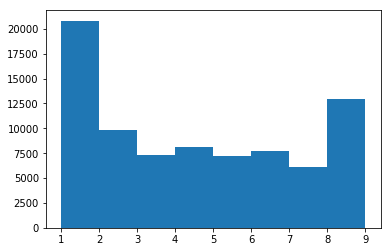

In [58]:
plt.hist(val_lst, bins=np.arange(1, 10))

# save

In [59]:
with open('train_d30.parenthesis.tsv', 'w') as ftrain, \
    open('valid_d30.parenthesis.tsv', 'w') as fvalid, \
    open('test_d30.parenthesis.tsv', 'w') as ftest:
    for es, f in zip([train, valid, test], [ftrain, fvalid, ftest]):
        for e in es:
            node_lst, sd_lst, h = e
            ds = list(map(int, sd_lst.split()))
            val = to_value_sd(ds, node_lst.split())[1]
            f.write('\t'.join([node_lst, sd_lst, h, val])+'\n')

# ave_length

In [60]:
lens = []
for e in train:
    node_lst, sd_lst, h = e
    lens.append(len(node_lst.split()))

In [62]:
print(np.average(lens))
print(np.var(lens))

13.81885
627.2802846775


(array([2.2628e+04, 0.0000e+00, 1.9001e+04, 0.0000e+00, 7.9270e+03,
        0.0000e+00, 5.5200e+03, 0.0000e+00, 3.7920e+03, 0.0000e+00,
        2.7590e+03, 0.0000e+00, 2.1640e+03, 0.0000e+00, 1.7700e+03,
        0.0000e+00, 1.5700e+03, 0.0000e+00, 1.3470e+03, 0.0000e+00,
        1.1130e+03, 0.0000e+00, 9.9000e+02, 0.0000e+00, 8.9500e+02,
        0.0000e+00, 7.6900e+02, 0.0000e+00, 7.0200e+02, 0.0000e+00,
        5.7100e+02, 0.0000e+00, 4.8400e+02, 0.0000e+00, 4.8700e+02,
        0.0000e+00, 3.6500e+02, 0.0000e+00, 3.3500e+02, 0.0000e+00,
        2.9200e+02, 0.0000e+00, 2.7000e+02, 0.0000e+00, 2.4700e+02,
        0.0000e+00, 2.0700e+02, 0.0000e+00, 1.8600e+02, 0.0000e+00,
        1.7400e+02, 0.0000e+00, 1.7200e+02, 0.0000e+00, 1.5800e+02,
        0.0000e+00, 1.3500e+02, 0.0000e+00, 1.2600e+02, 0.0000e+00,
        1.1000e+02, 0.0000e+00, 1.0300e+02, 0.0000e+00, 9.0000e+01,
        0.0000e+00, 8.8000e+01, 0.0000e+00, 1.0500e+02, 0.0000e+00,
        8.2000e+01, 0.0000e+00, 8.1000e+01, 0.00

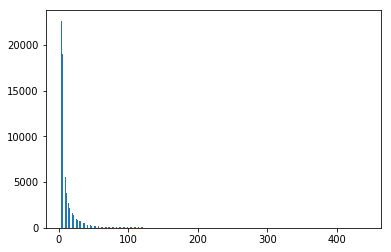

In [66]:
plt.hist(lens, bins=max(lens))

In [74]:
sum(np.array(lens) > 100)

1464

In [79]:
def expected_batch_len(es, bsz=32):
    lens = []
    for i in range(10000):
        batch = []
        for _ in range(bsz):
            e = random.choice(es)
            batch.append(len(e[0].split()))
        lens.append(max(batch))
        print(max(batch))
    return np.average(lens), np.var(lens)

In [80]:
expected_batch_len(train)

75
39
165
149
103
105
167
55
107
47
147
133
41
41
35
131
89
65
21
37
77
63
127
79
31
99
63
71
97
143
23
143
105
147
83
43
91
111
117
209
33
69
193
171
117
131
165
61
99
271
153
81
93
143
53
179
61
171
105
277
51
207
37
51
229
179
71
47
155
89
49
147
55
131
63
105
29
89
193
41
31
129
133
21
103
37
59
181
173
73
235
71
109
155
55
199
119
99
135
33
45
163
113
109
159
103
27
63
31
23
103
141
39
71
185
37
63
247
147
85
107
155
169
225
51
85
55
119
145
29
39
41
191
41
127
49
135
51
239
55
277
393
283
213
59
257
71
241
129
235
41
103
53
69
167
185
91
31
179
139
159
69
185
65
123
49
55
79
151
103
43
83
347
153
55
77
145
61
77
73
171
109
107
29
141
151
135
71
193
119
33
111
151
107
179
141
313
111
43
63
81
41
103
55
79
45
115
61
177
157
215
53
45
261
63
89
257
115
203
121
53
119
39
319
79
91
49
39
25
25
49
109
79
51
75
147
31
163
205
231
25
57
45
119
57
55
39
135
199
91
133
91
171
65
61
103
355
103
105
77
95
139
29
53
43
87
111
55
195
143
195
73
41
87
67
49
97
95
59
171
185
41
189
91
127
33
81


61
51
35
139
63
171
75
65
47
69
29
47
125
383
211
95
45
149
41
441
57
111
101
49
109
133
55
125
21
59
45
165
181
71
53
35
119
203
159
63
221
283
59
183
47
97
29
101
57
119
183
107
27
227
103
113
51
51
101
141
41
37
91
55
73
87
133
91
123
45
33
161
47
55
65
85
113
89
127
105
165
115
73
33
79
39
65
55
121
131
181
151
37
179
207
43
63
33
121
39
67
161
201
85
53
139
89
63
175
23
47
191
103
71
145
55
225
79
69
83
35
197
71
141
185
67
81
67
105
85
45
63
237
37
69
125
45
127
57
97
131
87
169
63
21
99
199
157
71
25
113
31
105
123
185
45
109
109
75
121
231
249
141
189
33
73
57
231
41
123
55
179
53
81
103
63
123
97
33
97
99
227
63
53
169
135
73
59
51
127
111
127
207
75
107
35
47
87
115
65
49
143
103
43
65
97
55
129
171
97
143
83
73
17
79
49
41
85
37
195
101
269
87
219
233
147
101
121
83
115
81
57
113
75
59
31
107
179
285
285
103
183
49
215
41
109
109
83
135
137
159
167
313
127
61
27
37
99
231
55
167
91
45
83
87
55
231
105
199
137
57
129
79
97
87
85
97
257
121
109
151
115
75
249
117
153
67
31
49


97
87
35
89
115
133
113
81
121
45
49
123
83
101
33
119
113
215
87
25
115
123
111
243
33
167
193
163
63
319
43
135
43
93
175
105
77
69
35
125
99
57
375
125
69
155
103
41
41
105
115
153
71
55
137
115
71
119
347
89
83
193
59
31
185
81
187
67
143
189
105
49
65
225
49
43
165
23
113
181
123
37
63
111
33
233
41
57
27
97
115
159
47
127
149
57
163
23
81
111
103
209
21
49
145
41
67
45
243
79
155
201
45
115
67
55
21
115
117
127
39
195
137
119
97
129
63
85
183
123
133
97
65
59
275
89
211
59
83
99
45
87
157
57
81
249
121
405
225
29
39
47
233
57
71
83
105
137
99
119
105
33
199
21
151
75
77
137
249
87
93
91
77
179
49
143
23
69
213
69
61
33
99
47
151
35
65
55
41
59
47
105
49
77
31
53
101
103
43
233
31
35
153
71
119
65
147
199
91
45
183
77
123
375
75
73
159
103
141
97
57
97
57
43
31
207
73
45
77
87
103
77
55
105
117
113
73
93
259
47
69
59
45
33
119
159
41
105
91
133
89
45
71
55
375
131
153
75
41
69
89
233
225
71
227
117
71
109
203
25
121
103
105
115
41
103
191
109
325
57
249
79
93
43
131
81
47
37
41
95

103
99
89
105
131
211
33
167
217
71
259
91
117
83
89
39
59
93
33
255
51
39
233
117
47
139
151
55
39
167
105
153
129
105
91
29
209
119
35
73
193
35
91
69
97
53
135
81
47
23
111
185
91
71
119
65
225
177
31
35
87
49
153
269
113
111
115
61
243
143
107
115
73
89
53
143
27
117
41
111
77
39
159
45
29
165
169
51
147
141
157
109
109
53
167
37
81
185
145
169
27
263
53
57
63
383
37
283
105
109
193
121
79
133
47
223
29
47
153
45
81
147
231
67
75
91
91
33
87
129
81
111
33
55
229
93
31
273
91
65
181
71
119
217
103
61
61
77
123
51
99
131
103
45
41
77
77
221
149
93
145
39
177
161
137
47
145
131
199
183
157
21
79
155
159
183
39
97
181
93
139
85
149
57
79
117
63
25
47
97
189
207
229
105
109
69
45
75
33
41
95
83
63
197
143
81
119
59
69
239
31
25
51
243
123
115
67
111
165
41
23
121
39
115
53
217
105
145
127
43
63
39
111
79
69
211
143
111
67
107
63
27
107
79
99
93
135
69
65
87
121
97
105
61
29
45
179
31
145
175
39
97
193
49
159
23
161
73
111
71
97
301
123
117
107
63
167
41
27
145
35
77
23
63
51
71
195
113


(107.103, 4560.148190999999)